#### Script to Analyze Noise Levels in Covid19 Amplicons ####

##### Created by: Karthikeyan Sivaraman and Esha Joshi
##### Organization: Public Health Ontario

###### Date: 03 December 2020

#### General Notes

The script uses information from processed Covid19 data [SNPs and Overall Readcounts] and calculates the conditional probability of noise, given an amplicon -- the assumption is that any variant in that amplicon will exhibit the same level of noise. This doesn't take into account the read depth of the SNPs in question and any subsequent effects.

The script uses the following data:

    1. sampleData.tsv -- a table of N samples x M amplicons with Plate information. The format is as follows
        a. Column 1: Plate
        b. Column 2: Sample ID
        c. Column 3 - Column 100: amplicon read count
    2. negData.tsv -- a similar table as sampleData, but for negative control data
    3. amplicon_var_frequency.tbl -- a four column tab delimited table with the following columns
        a. Amplicon ID
        b. Total Samples
        c. Var_Frequency in Amplicon
        d. Var_frequency / Total Samples
        The total samples is a constant. Var_Frequency is the number of times in all samples that an amplicon contains at least one variant. Multiple variants are not currently considered.
    4. Noise_var_frequency.tbl
        Similar to (3) - but for Noise Data.
    
The following steps are performed:

    1. For each amplicon, Calculate p(VarFreq | Noise) as follows: total variant in amplicon / no. of negative control samples
        a. Where (1) = 0, set a default minimum of p = 0.001 [arbitrary]
    2. Convert raw noise in each negative control amplicon to a fraction of total data per sample, as follows:
        a. p(noise) = noise / (data + noise)
    3. Calculate p(Variant) as follows:
        a. p(Variant) = sum ( p(VarFreq | Noise) * p(noise) ) [for all amplicons]
    4. Calculate conditional probability p(Noise | Variant in Amplicon) [or more simply, p(Noise | Variant)] as follows:
        a. p(N | V) for amplicon = p(V | N) . p(N) [for amplicon] / p(Variant) [from (3)]
 

In [1]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import random

import seaborn as sns

### Read All Data and Format it Appropriately as DataFrames

In [2]:
raw_data = pd.read_table('sampleData.tsv',header=None)
neg_data = pd.read_table('negData.tsv',header=None)
amplicon_var_freq=pd.read_table('amplicon_var_frequency.tbl',header=None)
amplicon_var_freq.columns=('Amplicon','Total','Var_Freq','pVarFreq')
noise_var = pd.read_table('Noise_var_frequency.tbl',header=None)
noise_var.columns=('Amplicon','Total','Var_Freq','pVarFreq')

In [3]:
string="Plate   sample  amp1    amp2    amp3    amp4    amp5    amp6    amp7    amp8    amp9    amp10   amp11   amp12   amp13   amp14   amp15   amp16   amp17   amp18   amp19   amp20   amp21   amp22   amp23   amp24   amp25   amp26   amp27   amp28   amp29   amp30   amp31   amp32   amp33   amp34   amp35   amp36   amp37   amp38   amp39   amp40   amp41   amp42   amp43   amp44   amp45   amp46   amp47   amp48   amp49   amp50   amp51   amp52   amp53   amp54   amp55   amp56   amp57   amp58   amp59   amp60   amp61   amp62   amp63   amp64   amp65   amp66   amp67   amp68   amp69   amp70   amp71   amp72   amp73   amp74   amp75   amp76   amp77   amp78   amp79   amp80   amp81   amp82   amp83   amp84   amp85   amp86   amp87   amp88   amp89   amp90   amp91   amp92   amp93   amp94   amp95   amp96   amp97   amp98"

In [4]:
amplicon_var_freq

Amplicon  Total  Var_Freq  pVarFreq
0      amp1   3137      2836   0.90404
1      amp2   3137        86   0.02741
2      amp3   3137       172   0.05482
3      amp4   3137      1241   0.39560
4      amp5   3137       304   0.09690
..      ...    ...       ...       ...
93    amp94   3137       138   0.04399
94    amp95   3137      1425   0.45425
95    amp96   3137       215   0.06853
96    amp97   3137       116   0.03697
97    amp98   3137       457   0.14568

[98 rows x 4 columns]

In [5]:
array=tuple(string.split())
raw_data.columns=array
neg_data.columns=array

In [6]:
noise_var['Total']=44 ## No of plates
noise_var['pVarFreq']=noise_var['Var_Freq']/noise_var['Total']
noise_var['pVarFreq'][noise_var['pVarFreq']==0]=0.001 ## Set default noise to 0.001

<ipython-input-6-a778544cc8f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noise_var['pVarFreq'][noise_var['pVarFreq']==0]=0.001 ## Set default noise to 0.001


In [7]:
### link samples to plates ####

plate_sample_dict={}
sample_plate_dict={}
for row in raw_data.iterrows():
    plate = row[1][0]
    sample = row[1][1]
    sample_plate_dict[sample]=plate
    if plate_sample_dict.get(plate) == None:
        plate_sample_dict[plate]=sample
    else:
        plate_sample_dict[plate] += str('\t' +sample)

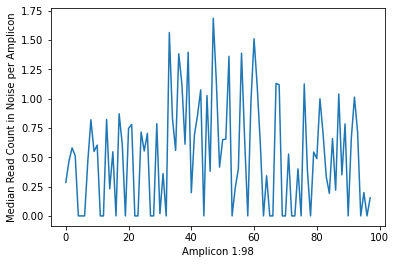

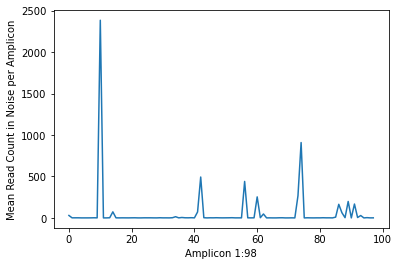

In [8]:
### Check how the data looks visually ###

average_neg = neg_data[neg_data.columns[2:100]].mean(axis=0)
median_neg = neg_data[neg_data.columns[2:100]].median(axis=0)
sns.lineplot(range(0,98),median_neg)
plt.ylabel('Median Read Count in Noise per Amplicon')
plt.xlabel('Amplicon 1:98')
plt.show()
sns.lineplot(range(0,98),average_neg)
plt.ylabel('Mean Read Count in Noise per Amplicon')
plt.xlabel('Amplicon 1:98')
plt.show()

In [9]:
### Create dictionaries for holding various data -- the names are quite self explanatory
### raw = raw data; neg = negative data ; negsum = summed negative data for all plates.

data_dict_raw={}
data_dict_neg={}
data_dict_negsum={}

In [10]:
### Fill in the dicts below using the data in the files. 

In [11]:
for plate in neg_data['Plate'].unique():
    data_dict_raw[plate] = raw_data[raw_data['Plate'] == plate][raw_data.columns[2:100]]
    data_dict_neg[plate] = neg_data[neg_data['Plate'] == plate][neg_data.columns[2:100]]
amplicon_list=list(array[2:100])
plates = neg_data['Plate'].unique()

In [12]:
for plate in plates:
    a = pd.DataFrame(data_dict_neg[plate]).sum(axis=0).transpose()
    index = 0
    for value in a:
        if value == 0:
            a[index] = 0.001 ## use a minimum default of 0.001 Noise value
        index += 1
    data_dict_negsum[plate]=a

In [13]:
### we will need a list of samples for processing below ###

samples=list(raw_data['sample'])

In [14]:
sample_dict={}
noise_prob_all={}
signal_prob_all={}

##### All the data is in desired form -- so we start data conversions here
##### First, we convert raw noise into noise per amplicon per sample using: p(Noise) = noise / (noise + data)
##### We also convert Signal into signal per amplicon / sample using: p(signal) = signal / (noise + signal)

In [15]:
##### 

for plate in plates:
    noise_prob_all[plate]={}
    signal_prob_all[plate]={}
    data={}
    data_sample={}
    for amp in amplicon_list:
        data[amp]={}
        data_sample[amp]={}
        noise = data_dict_negsum[plate][amp]
        for sam in samples:
            d = raw_data[raw_data['sample'] == sam][amp]
            data[amp][sam]=noise/(d + noise) # calculate noise as a ratio of noise to total data (signal + noise)
            data_sample[amp][sam]=d/(d+noise) # Calculate signal as a ratio of signal to total data (signal + noise)
    noise_prob_all[plate]=data
    signal_prob_all[plate]=data_sample
    print(plate)

Plate0001
Plate0002
Plate0003
Plate0004
Plate0005
Plate0006
Plate0007
Plate0008
Plate0009
Plate0010


#### Meat of calculation happens below

We pull noise from dict "noise_prob_all", and V|N from noise_var dict. 
We calculate the denominator as follows :: (p(noise) * p(variant_given_noise)) + (p(signal) * p(variant_given_signal)) 
Then we calculate posterior probabilities of (N | Variant) for each amplicon in each sample.

This is then stored in a dataframe --

In [18]:
p_variant={}
d2_=[]
#sam='PHLON20-SARS00920_S3_L001'
for sam in sample_plate_dict.keys():
    plate = sample_plate_dict[sam]
    d_={}
#plate = 'Plate0001'
    p_variant[sam] = {}
    sum_ = 0
    for amp in amplicon_list:
        noise = noise_prob_all[plate][amp][sam]
        signal = signal_prob_all[plate][amp][sam]
        variant_given_signal = float(amplicon_var_freq[amplicon_var_freq['Amplicon']==amp]['pVarFreq']) 
        variant_given_noise = noise_var[noise_var['Amplicon']==amp]['pVarFreq']
        
        pNoise = float(noise) * float(variant_given_noise) # calculate Noise likelihood
        pSignal = float(signal) * float(variant_given_signal) # calculate signal likelihood
        
        p_variant[sam][amp] = pSignal + pNoise ## denominator
        d_[amp] = pNoise

        #print(amp,float(noise),float(variant_given_noise),ding,sum_)
    for amp in amplicon_list:
        dx={}
        dx['Sample']=sam
        dx['Amplicon']=amp
        dx['Numerator']=d_[amp]
        dx['Denom'] = p_variant[sam]
        dx['Conditional'] = d_[amp] / p_variant[sam][amp]
        d2_.append(dx)
    print(sam) ## Print the sample name for monitoring - can be safely commented out

PHLON20-SARS00730-v2_S65_L001
PHLON20-SARS00731-v2_S68_L001
PHLON20-SARS00752-v2_S20_L001
PHLON20-SARS00918_S1_L001
PHLON20-SARS00919_S2_L001
PHLON20-SARS00920_S3_L001
PHLON20-SARS00921_S4_L001
PHLON20-SARS00922_S5_L001
PHLON20-SARS00923_S6_L001
PHLON20-SARS00924_S7_L001
PHLON20-SARS00925_S8_L001
PHLON20-SARS00926_S9_L001
PHLON20-SARS00927_S10_L001
PHLON20-SARS00928_S11_L001
PHLON20-SARS00929_S12_L001
PHLON20-SARS00930_S13_L001
PHLON20-SARS00931_S14_L001
PHLON20-SARS00932_S15_L001
PHLON20-SARS00933_S16_L001
PHLON20-SARS00934_S17_L001
PHLON20-SARS00935_S18_L001
PHLON20-SARS00936_S19_L001
PHLON20-SARS00937_S21_L001
PHLON20-SARS00938_S22_L001
PHLON20-SARS00939_S23_L001
PHLON20-SARS00940_S24_L001
PHLON20-SARS00941_S25_L001
PHLON20-SARS00942_S26_L001
PHLON20-SARS00943_S27_L001
PHLON20-SARS00944_S28_L001
PHLON20-SARS00945_S29_L001
PHLON20-SARS00946_S30_L001
PHLON20-SARS00947_S31_L001
PHLON20-SARS00948_S32_L001
PHLON20-SARS00949_S33_L001
PHLON20-SARS00950_S34_L001
PHLON20-SARS00951_S35_L001
P

PHLON20-SARS01795_S42_L001
PHLON20-SARS01796_S43_L001
PHLON20-SARS01797_S44_L001
PHLON20-SARS01798_S45_L001
PHLON20-SARS01799_S46_L001
PHLON20-SARS01800_S47_L001
PHLON20-SARS01801_S48_L001
PHLON20-SARS01802_S49_L001
PHLON20-SARS01803_S50_L001
PHLON20-SARS01804_S51_L001
PHLON20-SARS01805_S52_L001
PHLON20-SARS01806_S53_L001
PHLON20-SARS01807_S54_L001
PHLON20-SARS01808_S55_L001
PHLON20-SARS01809_S56_L001
PHLON20-SARS01810_S57_L001
PHLON20-SARS01811_S58_L001
PHLON20-SARS01812_S59_L001
PHLON20-SARS01813_S60_L001
PHLON20-SARS01814_S61_L001
PHLON20-SARS01815_S62_L001
PHLON20-SARS01816_S63_L001
PHLON20-SARS01817_S64_L001
PHLON20-SARS01818_S65_L001
PHLON20-SARS00239_S1_L001
PHLON20-SARS00240_S2_L001
PHLON20-SARS00241_S3_L001
PHLON20-SARS00242_S4_L001
PHLON20-SARS00243_S5_L001
PHLON20-SARS00244_S6_L001
PHLON20-SARS00245_S7_L001
PHLON20-SARS00246_S8_L001
PHLON20-SARS00247_S9_L001
PHLON20-SARS00248_S10_L001
PHLON20-SARS00249_S11_L001
PHLON20-SARS00250_S12_L001
PHLON20-SARS00251_S13_L001
PHLON20-SA

PHLON20-SARS00783_S26_L001
PHLON20-SARS00784_S27_L001
PHLON20-SARS00785_S28_L001
PHLON20-SARS00786_S29_L001
PHLON20-SARS00787_S30_L001
PHLON20-SARS00788_S31_L001
PHLON20-SARS00789_S32_L001
PHLON20-SARS00790_S33_L001
PHLON20-SARS00791_S34_L001
PHLON20-SARS00792_S35_L001
PHLON20-SARS00793_S36_L001
PHLON20-SARS00794_S37_L001
PHLON20-SARS00795_S38_L001
PHLON20-SARS00796_S39_L001
PHLON20-SARS00797_S40_L001
PHLON20-SARS00798_S41_L001
PHLON20-SARS00799_S42_L001
PHLON20-SARS00800_S43_L001
PHLON20-SARS00801_S44_L001
PHLON20-SARS00802_S45_L001
PHLON20-SARS00803_S46_L001
PHLON20-SARS00804_S47_L001
PHLON20-SARS00805_S48_L001
PHLON20-SARS00806_S49_L001
PHLON20-SARS00807_S50_L001
PHLON20-SARS00808_S51_L001
PHLON20-SARS00809_S52_L001
PHLON20-SARS00810_S53_L001
PHLON20-SARS00811_S54_L001
PHLON20-SARS00812_S55_L001
PHLON20-SARS00813_S56_L001
PHLON20-SARS00814_S57_L001
PHLON20-SARS00815_S58_L001
PHLON20-SARS00816_S59_L001
PHLON20-SARS00817_S60_L001
PHLON20-SARS00818_S61_L001
PHLON20-SARS00819_S62_L001
P

In [20]:
## read the results data_struct-list into a pandas dataframe

results=pd.DataFrame(d2_)

### Save sample wise results in a figure - a barplot that shows amplicon level posterior.
### Next step, save the results in an excel sheet for sharing

In [21]:
for i in samples:
    x = results[results['Sample'] == i]
    plt.figure(figsize=(16,6))
    output_plot = sns.barplot(x['Amplicon'],x['Conditional'])
    output_plot=plt.setp(output_plot.get_xticklabels(), rotation=45)
    plt.title('Sample ' + i)
    plt.savefig(i+'.png',dpi=300)
    print(i) ## Again printing sample ID for monitoring. Can be safely commented out
    plt.close()

PHLON20-SARS00730-v2_S65_L001
PHLON20-SARS00731-v2_S68_L001
PHLON20-SARS00752-v2_S20_L001
PHLON20-SARS00918_S1_L001
PHLON20-SARS00919_S2_L001
PHLON20-SARS00920_S3_L001
PHLON20-SARS00921_S4_L001
PHLON20-SARS00922_S5_L001
PHLON20-SARS00923_S6_L001
PHLON20-SARS00924_S7_L001
PHLON20-SARS00925_S8_L001
PHLON20-SARS00926_S9_L001
PHLON20-SARS00927_S10_L001
PHLON20-SARS00928_S11_L001
PHLON20-SARS00929_S12_L001
PHLON20-SARS00930_S13_L001
PHLON20-SARS00931_S14_L001
PHLON20-SARS00932_S15_L001
PHLON20-SARS00933_S16_L001
PHLON20-SARS00934_S17_L001
PHLON20-SARS00935_S18_L001
PHLON20-SARS00936_S19_L001
PHLON20-SARS00937_S21_L001
PHLON20-SARS00938_S22_L001
PHLON20-SARS00939_S23_L001
PHLON20-SARS00940_S24_L001
PHLON20-SARS00941_S25_L001
PHLON20-SARS00942_S26_L001
PHLON20-SARS00943_S27_L001
PHLON20-SARS00944_S28_L001
PHLON20-SARS00945_S29_L001
PHLON20-SARS00946_S30_L001
PHLON20-SARS00947_S31_L001
PHLON20-SARS00948_S32_L001
PHLON20-SARS00949_S33_L001
PHLON20-SARS00950_S34_L001
PHLON20-SARS00951_S35_L001
P

PHLON20-SARS01791_S38_L001
PHLON20-SARS01792_S39_L001
PHLON20-SARS01793_S40_L001
PHLON20-SARS01794_S41_L001
PHLON20-SARS01795_S42_L001
PHLON20-SARS01796_S43_L001
PHLON20-SARS01797_S44_L001
PHLON20-SARS01798_S45_L001
PHLON20-SARS01799_S46_L001
PHLON20-SARS01800_S47_L001
PHLON20-SARS01801_S48_L001
PHLON20-SARS01802_S49_L001
PHLON20-SARS01803_S50_L001
PHLON20-SARS01804_S51_L001
PHLON20-SARS01805_S52_L001
PHLON20-SARS01806_S53_L001
PHLON20-SARS01807_S54_L001
PHLON20-SARS01808_S55_L001
PHLON20-SARS01809_S56_L001
PHLON20-SARS01810_S57_L001
PHLON20-SARS01811_S58_L001
PHLON20-SARS01812_S59_L001
PHLON20-SARS01813_S60_L001
PHLON20-SARS01814_S61_L001
PHLON20-SARS01815_S62_L001
PHLON20-SARS01816_S63_L001
PHLON20-SARS01817_S64_L001
PHLON20-SARS01818_S65_L001
PHLON20-SARS00239_S1_L001
PHLON20-SARS00240_S2_L001
PHLON20-SARS00241_S3_L001
PHLON20-SARS00242_S4_L001
PHLON20-SARS00243_S5_L001
PHLON20-SARS00244_S6_L001
PHLON20-SARS00245_S7_L001
PHLON20-SARS00246_S8_L001
PHLON20-SARS00247_S9_L001
PHLON20-SA

PHLON20-SARS00776_S19_L001
PHLON20-SARS00777_S20_L001
PHLON20-SARS00778_S21_L001
PHLON20-SARS00779_S22_L001
PHLON20-SARS00780_S23_L001
PHLON20-SARS00781_S24_L001
PHLON20-SARS00782_S25_L001
PHLON20-SARS00783_S26_L001
PHLON20-SARS00784_S27_L001
PHLON20-SARS00785_S28_L001
PHLON20-SARS00786_S29_L001
PHLON20-SARS00787_S30_L001
PHLON20-SARS00788_S31_L001
PHLON20-SARS00789_S32_L001
PHLON20-SARS00790_S33_L001
PHLON20-SARS00791_S34_L001
PHLON20-SARS00792_S35_L001
PHLON20-SARS00793_S36_L001
PHLON20-SARS00794_S37_L001
PHLON20-SARS00795_S38_L001
PHLON20-SARS00796_S39_L001
PHLON20-SARS00797_S40_L001
PHLON20-SARS00798_S41_L001
PHLON20-SARS00799_S42_L001
PHLON20-SARS00800_S43_L001
PHLON20-SARS00801_S44_L001
PHLON20-SARS00802_S45_L001
PHLON20-SARS00803_S46_L001
PHLON20-SARS00804_S47_L001
PHLON20-SARS00805_S48_L001
PHLON20-SARS00806_S49_L001
PHLON20-SARS00807_S50_L001
PHLON20-SARS00808_S51_L001
PHLON20-SARS00809_S52_L001
PHLON20-SARS00810_S53_L001
PHLON20-SARS00811_S54_L001
PHLON20-SARS00812_S55_L001
P

In [22]:
results.to_excel("Conditional_Probability.xlsx",sheet_name='conditional_Prob')

### We do some basic Analytics on the Data

In [24]:
# How many amplicons have at least one instance of their posterior greater than 0.1?

len(results[results['Conditional'] > 0.1]['Amplicon'].unique())

98

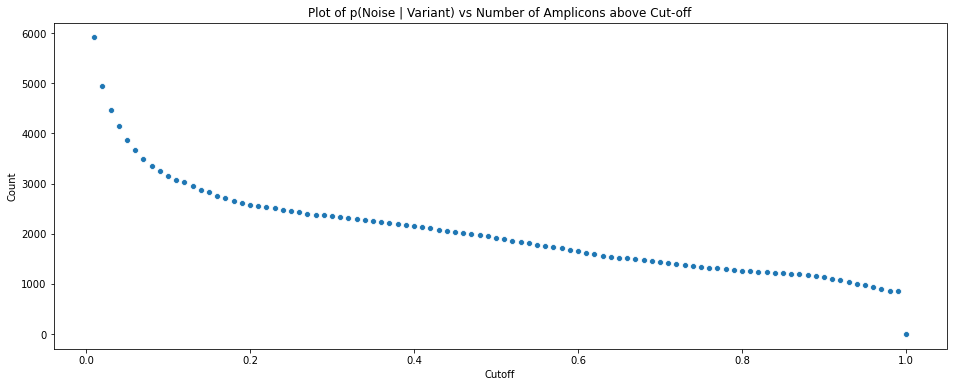

In [25]:
## Am curious as to how the noise falls as I relax the posterior cutoff - going in steps of 0.01 from 0.01 to 1.0

cumul_limit=[]
for i in range(1,101):
    cutoff = i / 100;
    d_={}
    d_['Cutoff']=cutoff
    d_['Count'] = len(results[results['Conditional'] > cutoff])
    cumul_limit.append(d_)

cumul_distrib=pd.DataFrame(cumul_limit)

plt.figure(figsize=(16,6))
plot=sns.scatterplot(cumul_distrib['Cutoff'],cumul_distrib['Count'])
plt.title('Plot of p(Noise | Variant) vs Number of Amplicons above Cut-off')
plt.savefig('Noise_vs_AmpCount.png',dpi=300)

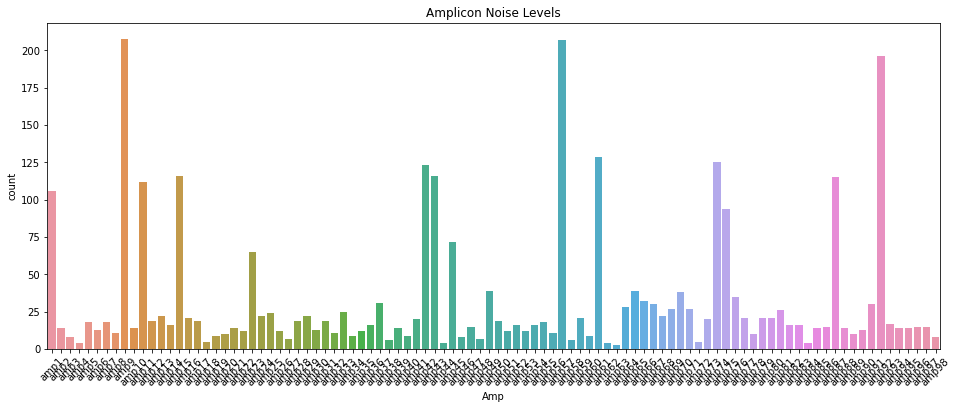

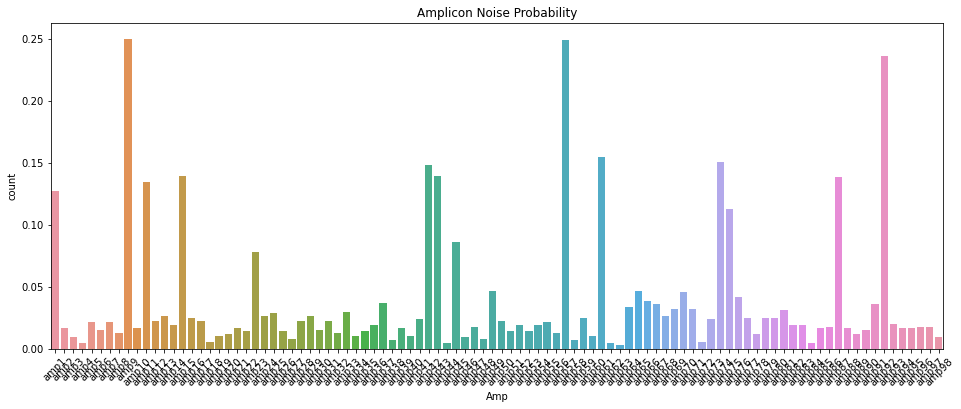

Amp  count
0    amp1    106
8    amp9    208
10  amp11    112
14  amp15    116
41  amp42    123
42  amp43    116
56  amp57    207
60  amp61    129
73  amp74    125
74  amp75     94
86  amp87    115
91  amp92    196

In [26]:
### We ask how many times does an amplicon show noisy behaviour? [Noise defined as posterior > 0.1]
d_=[]
for amp in amplicon_list:
    dict_={}
    x = results[results['Amplicon']==amp]
    dict_['Amp']=amp
    dict_['count']=len(x[x['Conditional'] > 0.1])
    d_.append(dict_)
    
amplicon_noise=pd.DataFrame(d_)

plt.figure(figsize=(16,6))    
a=sns.barplot(amplicon_noise['Amp'],amplicon_noise['count'])
plt.setp(a.get_xticklabels(), rotation=45)
plt.title('Amplicon Noise Levels')
plt.show()


### Next, I want to see what is the p(Noisy data) across the amplicons?

plt.figure(figsize=(16,6))    
a=sns.barplot(amplicon_noise['Amp'],amplicon_noise['count']/len(samples))
plt.setp(a.get_xticklabels(), rotation=45)
plt.title('Amplicon Noise Probability')
plt.show()


### I can ask how many amplicons have a high noise, more than 10% of times?

amplicon_noise[amplicon_noise['count']/len(samples) > 0.1]

For the 800 given samples -- these are my troublesome Amplicons. Particularly, Amplicons 1, 87 and 92 exhibit very high noise levels given the data. 

Have fun playing around.